# H$_\alpha$ and [OIII] correlations


In this notebook I focus on the comparison of the CIGALE outputs for SFR in the COSMOS and GOODS-S field mainly using the H$_\alpha$ and the [OIII] lines. 

The CIGALE outputs will be taken as the best models based on the work of B. Argence & F. Lamareille., 2009 where they compared CL01 models to dusta attenuation corrected SFRs using H$_\alpha$ as in Keniccutt., 1998, a proposed power law, single-line and double-line calibrations when no dust information is available.

Following Suzuki et al., 2016 we can also compare to the beta-slope method.However, they separated the samples in three different ones due to the fact that [OIII] emitters somehow are biased in comparison to H$_\alpha$ to larger sSFRuv. 

I will use a combination of both methods to study my sample in which I plan to use CIGALE as the correct method and compare it to all the possible versions. Also splitting the whole sample into different emitters to see if something is changes.

I will exclude the AGN sources by: 
                                   
                                   i) comparing to CIGALE agn_frac

                                   ii) using the IRAC bands method, or/and 
                                   
                                   iii) simply excluding all the x-ray data

In [208]:
# Regular packages

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
import os
from matplotlib.legend_handler import HandlerPathCollection
import pandas as pd
import warnings
import scipy.integrate as integrate
from scipy.optimize import curve_fit

%matplotlib inline

In [268]:
# Functions
#--------------------------------------------------------

# Values taken from https://arxiv.org/pdf/1807.06209.pdf
H0 = 2.184e-21 # km s^−1 m^−1 (67.4 km s^−1 Mpc^−1)
c  = 2.99792e5 # km s^−1
Om = 0.315
Ol = 1.0 - Om

# Line-emission luminosity
def flux_to_luminosity(flux, z ,Om, Ol, c, H0):
        
    d = (c/H0)*(1.0 + z)
    
    integral = integrate.quad(lambda x: ((1.0 + x)**2*(1.0 + Om*x) - Ol*x*(2.0 + x))**(-1.0/2.0), 0.0, z)
    
    L = 4.0*np.pi*( d*integral[0] )**2*flux
    
    return(L*1e7) # From Watts to erg s^-1

# Data: Observations + CIGALE outputs

In [269]:
# Data with all the info
# This data is the one with all the info before creating the Original data which was used in CIGALE

COSMOS = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/'
                    'COSMOS_GOODS-S_MosphoXray_Sample/Crossmatch_ContsantObjects/'
                    'COSMOS_mine_morpho_xraychandra.fits', format = 'fits')
GOODSS = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/'
                    'COSMOS_GOODS-S_MosphoXray_Sample/Crossmatch_ContsantObjects/'
                    'GOODSS_mine_morpho_xraychandra_NUV.fits', format = 'fits')

# Original data
# This is the file used in CIGALE

COSMOS_cigale = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/'
                           'Final_samples/COSMOS_HaOIII_all.fits', format = 'fits')
GOODSS_cigale = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/'
                           'Final_samples/GOODSS_HaOIII_all.fits', format = 'fits')

# Data from CIGALE

# Calzetti recipe

# COSMOS_Calzetti_results = Table.read('', format = 'ascii') 
# GOODSS_Calzetti_results =  Table.read('', format = 'ascii')

# CF00 recipe

COSMOS_CF00_results = Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/'
                                 'AGN_cigale_runs/No_AGN_module/COSMOS_CF00_HaOIII_noAGN.txt', format = 'ascii') 
GOODSS_CF00_results =  Table.read('/home/jvilla/Documents/PhD_2018/3DHST_Data/'
                                 'AGN_cigale_runs/No_AGN_module/GOODSS_CF00_HaOIII_noAGN.txt', format = 'ascii')

# Excluding Xray i.e. AGNs from both samples

In [270]:
COSMOS = COSMOS.to_pandas()
GOODSS = GOODSS.to_pandas()

COSMOS = COSMOS.fillna(-9999.99)
GOODSS = GOODSS.fillna(-9999.99)

COSMOS = Table.from_pandas(COSMOS)
GOODSS = Table.from_pandas(GOODSS)


COSMOS_xray = COSMOS[(COSMOS['flux_F'] <= 0) ^ (COSMOS['flux_S'] <= 0) ^ (COSMOS['flux_H'] <= 0)]
GOODSS_xray = GOODSS[(GOODSS['FLUX_FULL'] <= 0) ^ (GOODSS['FLUX_SOFT'] <= 0) ^ (GOODSS['FLUX_HARD'] <= 0)]

print('No-Xray data in COSMOS: %i'%len(COSMOS_xray))
print('No-Xray data in GOODSS: %i'%len(GOODSS_xray))

No-Xray data in COSMOS: 3648
No-Xray data in GOODSS: 1525


In [271]:
COSMOS_cigale = COSMOS_cigale[(COSMOS['flux_F'] <= 0) ^ (COSMOS['flux_S'] <= 0) ^ (COSMOS['flux_H'] <= 0)]
GOODSS_cigale = GOODSS_cigale[(GOODSS['FLUX_FULL'] <= 0) ^ (GOODSS['FLUX_SOFT'] <= 0) ^ (GOODSS['FLUX_HARD'] <= 0)]

COSMOS_CF00_results = COSMOS_CF00_results[(COSMOS['flux_F'] <= 0) ^ (COSMOS['flux_S'] <= 0) ^ (COSMOS['flux_H'] <= 0)]
GOODSS_CF00_results = GOODSS_CF00_results[(GOODSS['FLUX_FULL'] <= 0) ^ (GOODSS['FLUX_SOFT'] <= 0) ^ (GOODSS['FLUX_HARD'] <= 0)]

In [272]:
# COSMOS_CF00_results = COSMOS_CF00_results[(COSMOS_CF00_results['best.line.NII-654.8+line.H-alpha+line.NII-658.4'] >= 0)]
# GOODSS_CF00_results = GOODSS_CF00_results[(GOODSS_CF00_results['best.line.NII-654.8+line.H-alpha+line.NII-658.4'] >= 0)]

# Star-Formation Rate calibrations

# H$_\alpha$ calibration - Kennicutt., 1998

In [273]:
COSMOS_Halpha         = []
COSMOS_Halpha_results = []

for i in range(len(COSMOS_cigale)):
    
    COSMOS_L_Halpha = flux_to_luminosity(flux=COSMOS_cigale['line.NII-654.8+line.H-alpha+line.NII-658.4'][i], z=COSMOS_cigale['redshift'][i], Om=Om, Ol=Ol, c=c, H0=H0)
    COSMOS_Halpha.append(COSMOS_L_Halpha)
    
    COSMOS_L_Halpha_results = flux_to_luminosity(flux=COSMOS_CF00_results['best.line.NII-654.8+line.H-alpha+line.NII-658.4'][i], z=COSMOS_CF00_results['best.universe.redshift'][i], Om=Om, Ol=Ol, c=c, H0=H0)
#     COSMOS_L_Halpha_results = flux_to_luminosity(flux=COSMOS_CF00_results['best.line.NII-654.8+line.H-alpha+line.NII-658.4'][i], z=COSMOS_cigale['redshift'][i], Om=Om, Ol=Ol, c=c, H0=H0)
    COSMOS_Halpha_results.append(COSMOS_L_Halpha_results)
    
GOODSS_Halpha         = []
GOODSS_Halpha_results = []

for i in range(len(GOODSS_cigale)):
    
    GOODSS_L_Halpha = flux_to_luminosity(flux=GOODSS_cigale['line.NII-654.8+line.H-alpha+line.NII-658.4'][i], z=GOODSS_cigale['redshift'][i], Om=Om, Ol=Ol, c=c, H0=H0)
    GOODSS_Halpha.append(GOODSS_L_Halpha) 
    
    GOODSS_L_Halpha_results = flux_to_luminosity(flux=GOODSS_CF00_results['best.line.NII-654.8+line.H-alpha+line.NII-658.4'][i], z=GOODSS_CF00_results['best.universe.redshift'][i], Om=Om, Ol=Ol, c=c, H0=H0)
    GOODSS_Halpha_results.append(GOODSS_L_Halpha_results)  

1.0 1.0


/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/jvilla/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/home/jvilla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log10


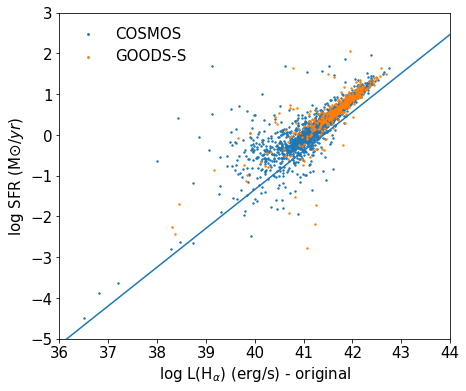

In [279]:
# From Suzuki et al., 2016
# L_Ha is already in erg s^-1

def SFR_kennicutt_98(L_Ha):
    return( np.multiply(7.9e-42, L_Ha) )

def model_SFR(x, a, b):
    return( a*np.log10(x) - np.log10(b))

# COSMOS_Halpha = np.array(COSMOS_Halpha)
# GOODSS_Halpha = np.array(GOODSS_Halpha)
# COSMOS_Halpha_results = np.array(COSMOS_Halpha_results)
# GOODSS_Halpha_results = np.array(GOODSS_Halpha_results)

# COSMOS_Halpha_results = COSMOS_Halpha_results[COSMOS_Halpha_results > 0]
# GOODSS_Halpha_results = GOODSS_Halpha_results[GOODSS_Halpha_results > 0]
# COSMOS_Halpha = COSMOS_Halpha[COSMOS_Halpha_results > 0]
# GOODSS_Halpha = GOODSS_Halpha[GOODSS_Halpha_results > 0]


popt_COSMOS, pcov_COSMOS = curve_fit(model_SFR, COSMOS_Halpha_results, SFR_kennicutt_98(COSMOS_Halpha))
# popt_GOODSS, pcov_GOODSS = curve_fit(model_SFR, GOODSS_Halpha_results, SFR_kennicutt_98(GOODSS_Halpha))

print(*popt_COSMOS)
# print(*popt_GOODSS)

plt.figure(figsize = (7, 6))
# plt.scatter(np.log10(COSMOS_Halpha), np.log10(SFR_kennicutt_98(COSMOS_Halpha)))
# plt.scatter(np.log10(GOODSS_Halpha), np.log10(SFR_kennicutt_98(GOODSS_Halpha)))
plt.scatter(np.log10(COSMOS_Halpha_results), np.log10(SFR_kennicutt_98(COSMOS_Halpha)), s = 2, label = 'COSMOS')
plt.scatter(np.log10(GOODSS_Halpha_results), np.log10(SFR_kennicutt_98(GOODSS_Halpha)), s = 2, label = 'GOODS-S')
plt.plot(np.linspace(30, 50, 100), 0.951*np.linspace(30, 50, 100)-39.38)
plt.ylim(-5, 3)
plt.xlim(36, 44)
plt.xlabel(r'log L(H$_\alpha$) (erg/s) - original', fontsize = 15)
plt.ylabel(r'log SFR (M$\odot/yr$)', fontsize = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.legend(frameon = False, prop = {'size': 15}, markerscale = 1.3 , loc = 'upper left')

# Balmer decrement

# [OIII]/H$_\alpha^i$ calibration

# Signle-line calibration using H$_\alpha$ and [OIII] observations

# Two-line calibration using [OIII]/H$_\alpha^i$ to infer [OIII]/H$_\beta$

# UV-$\beta$ slope method